In [1]:
# -*- coding:utf-8 -*-
import json
import requests
import csv,re,os,math,glob
from lxml import etree
from datetime import date,datetime
import pandas as pd
from copy import deepcopy
import numpy as np
import matplotlib.pyplot as plt
import hashlib #check md5sum of rawdata files
import scipy.stats as stats
from scipy.optimize import curve_fit
####新项目，近5年分红去高去低*回购率排名，同时要求分红逆序数（假）不能超过6
# 爬取底层证券的现金及现金等价物，取过去两年，线性回归，计算超过转债赎回价格的概率。
# 先改成用一部分回归然后看整体的mse吧。
# 神经网络 输入价格，转股价值，转债占比，剩余年限，强赎概率，下调转股价条件(redeem_inc_cpn_fl)

In [2]:
#Save_interest_rate

In [3]:
def save_interest_rate(data):
    
    # 1. 创建文件对象
    f = open('CB_interest_rate.csv', 'w', encoding='utf-8', newline='')
    # 2. 基于文件对象构建 csv写入对象
    csv_writer = csv.writer(f)
    # 3. 构建列表头
    csv_writer.writerow(["id","iry1", "iry2", "iry3", "iry4", "iry5", "iry6"])
    
    count = 0
    for item in data:
        count +=1
        if (count %10 == 0):
            print("processing "+str(count)+" items")
        try:
            interest = get_interest_rate(item['id'])
            interest = [item['id']]+interest
            csv_writer.writerow(interest)
        except Exception as e:
            print("Oops!", e.__class__, "occurred.")
            print("The error happed at "+item['id'])
    # 5. 关闭文件
    print("Finished processing "+str(count)+" items")
    f.close()


In [4]:
#append_interest_rate

In [5]:
def append_interest_rate(item):
    
    # 1. 创建文件对象
    interest_dict = get_interest_dict('CB_interest_rate.csv')
    if item['id'] in interest_dict:
        return
    f = open('CB_interest_rate.csv', 'a', encoding='utf-8', newline='')
    # 2. 基于文件对象构建 csv写入对象
    csv_writer = csv.writer(f)
    
    

    try:
        interest = get_interest_rate(item['id'])
        interest = [item['id']]+interest
        csv_writer.writerow(interest)
        print("Finished appending new CB "+ item['name']+" into interest rate files")
    except Exception as e:
        print("Oops!", e.__class__, "occurred.")
        print("The error happed at "+item['id'])
    
    # 5. 关闭文件
    
    f.close()


In [6]:
#get_interest_rate

In [7]:
def get_interest_rate(id):
    years = 6
    detials_url = 'https://www.jisilu.cn/data/convert_bond_detail/'+id
    detials_response = requests.get(detials_url)
    html = detials_response.content.decode("utf-8")
    html = etree.HTML(html)
    interest_text = html.xpath('.//td[@id="cpn_desc"]/text()')
    if(not interest_text[0].find('%')):
        print(" not in interest test %s %s"%(id,interest_text))
        pattern = re.compile(r'(?<!\d|\.)\d+(?:\.\d+)?')  #get proper format number
    else:
        pattern = re.compile(r'(?<!\d|\.)\d+(?:\.\d+)?\s?%')  #get proper format number
    interest = pattern.findall(interest_text[0])
    if(len(interest) <= 1):
        print("%s fixed interest rate %s"%(id, interest_text[0]))
        interest = interest*years
    elif(len(interest)<5):
        print("%s number of interest rate between 2-4 %s"%(id, interest_text[0]))
        print("You may need to check manually")
    elif(len(interest)>6):
        print("%s number of interest rate greater than 6 %s"%(id, interest_text[0]))
        print("You may need to check manually")
    interest = [rate.strip("%") for rate in interest]
    return interest

In [8]:
# get interest dict

In [9]:
def get_interest_dict(file):
    interest_dict = dict()
    with open(file) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        line_count = 0
        for row in csv_reader:
            if line_count == 0:
                #skip header
                line_count += 1
            else:
                interest_dict[row[0]] = row[1:]
                line_count += 1
        print(f'Processed {line_count} lines.')
    return interest_dict


In [10]:
# buy or sell cb

In [11]:
def buy_sell_db(db_df,file,show_price=False):
    db_df = db_df[(db_df['force_redeem'] != 'Y')]
    total_number = len(db_df)
    quartile = np.percentile(db_df['db_low'],25) ##first quartile
    keep_number = int(total_number*0.1)  ##10th percentile
    buy_number  = int(total_number*0.05) ##5th percentile
    add_number = int(total_number*0.02)  ##2th percentile
    
    keep_dict = {i:db_df['name'][i] for i in db_df[0:keep_number].index}
    buy_dict = {i:db_df['name'][i] for i in db_df[0:buy_number].index}
    add_dict = {i:db_df['name'][i] for i in db_df[0:add_number].index}
    sell_count = 0
    holding_dict = dict()
    
    ##sell
    my_list = []
    with open(file) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        for row in csv_reader:
            cb_id,cb_name,_,_ = row
            if cb_id not in db_df.index:
                print("%s %s %s"%(cb_id,cb_name,'not in lists'))
                continue
            holding_dict[cb_id] = cb_name
            price = db_df.loc[cb_id]['price']
            db_low = db_df.loc[cb_id]['db_low']
            item = {'id':cb_id,'name':cb_name,'price':price,'db_low':db_low}
            my_list.append(item)
            if cb_id not in keep_dict.keys():
                sell = "Sell"
                if(db_low>quartile):
                    sell = "Strong Sell"
                if(show_price):
                    print("%s %s %s %s %.3f"%(sell,cb_id,cb_name,price,db_low))
                else:
                    print("%s %s %s"%(sell,cb_id,cb_name))
                sell_count += 1
    if(sell_count==0):
        print('No CB to sell')
        
    ##buy
    print()
    for cb_id,cb_name in add_dict.items():
        price = db_df.loc[cb_id]['price']
        db_low = db_df.loc[cb_id]['db_low']
        if(show_price):
            print("Add  %s %s %s %.3f"%(cb_id,cb_name,price,db_low))
        else:
            print("Add  %s %s"%(cb_id,cb_name))
    print()
    for cb_id in buy_dict.keys():
        if cb_id not in holding_dict.keys():
            price = db_df.loc[cb_id]['price']
            db_low = db_df.loc[cb_id]['db_low']
            cb_name = keep_dict[cb_id]
            if(show_price):
                print("Buy  %s %s %s %.3f"%(cb_id,cb_name,price,db_low))
            else:
                print("Buy  %s %s"%(cb_id,cb_name))
    
    my_df = pd.DataFrame(my_list)
    my_df = my_df.set_index(['id'])
    my_df = my_df.sort_values('db_low',ascending=True)
    return my_df,buy_dict
    

In [12]:
#buy sell low

In [13]:
def buy_sell_low(lp_df,db_buy_dict,file,show_price=False):
    total_number = len(lp_df)
    quartile = np.percentile(lp_df['lower_deviation'],25) ##first quartile
    keep_number = int(total_number*0.1)  ##10th percentile
    buy_number  = int(total_number*0.05) ##5th percentile
    add_number = int(total_number*0.02)  ##2th percentile
    
    keep_dict = {i:lp_df['name'][i] for i in lp_df[0:keep_number].index}
    buy_dict = {i:lp_df['name'][i] for i in lp_df[0:buy_number].index}
    add_dict = {i:lp_df['name'][i] for i in lp_df[0:add_number].index}
    sell_count = 0
    holding_dict = dict()
    
    ##sell
    my_list = []
    with open(file) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        for row in csv_reader:
            cb_id,cb_name,_,_ = row
            if cb_id not in lp_df.index:
                print("%s %s %s"%(cb_id,cb_name,'not in lists'))
                sell_count += 1
                continue
            holding_dict[cb_id] = cb_name
            price = lp_df.loc[cb_id]['price']
            db_low  = lp_df.loc[cb_id]['db_low']
            premium = lp_df.loc[cb_id]['premium']
            lower_deviation = lp_df.loc[cb_id]['lower_deviation']
            fit_price = lp_df.loc[cb_id]['fit_price']
            low_fit_price = lp_df.loc[cb_id]['low_fit_price']
            upper_fit_price = lp_df.loc[cb_id]['upper_fit_price']
            item = {'id':cb_id,'name':cb_name,'price':price,'db_low':db_low,'premium':premium,
                    'lower_deviation':lower_deviation}
            my_list.append(item)
            if cb_id not in keep_dict.keys() or price>fit_price:
                sell = "Sell"
                if(lower_deviation>quartile or price>upper_fit_price):
                    sell = "Strong Sell"
                if(show_price):
                    print("%s %s %s %s %.3f %.3f %.3f"
                          %(sell,cb_id,cb_name,price,db_low,premium,lower_deviation))
                else:
                    print("%s %s %s"%(sell,cb_id,cb_name))
                sell_count += 1
    if(sell_count==0):
        print('No CB to sell')
        
    ##buy
    print()
    for cb_id,cb_name in add_dict.items():
        price = lp_df.loc[cb_id]['price']
        db_low  = lp_df.loc[cb_id]['db_low']
        premium = lp_df.loc[cb_id]['premium']
        lower_deviation = lp_df.loc[cb_id]['lower_deviation']
        low_fit_price = lp_df.loc[cb_id]['low_fit_price']
        if price>=low_fit_price:
            continue
        if(show_price):
            print("Add  %s %s %s %.3f %.3f %.3f"
                  %(cb_id,cb_name,price,db_low,premium,lower_deviation))
        else:
            print("Add  %s %s"%(cb_id,cb_name))
    print()
    for cb_id,cb_name in buy_dict.items():
        price = lp_df.loc[cb_id]['price']
        db_low  = lp_df.loc[cb_id]['db_low']
        premium = lp_df.loc[cb_id]['premium']
        lower_deviation = lp_df.loc[cb_id]['lower_deviation']
        low_fit_price = lp_df.loc[cb_id]['low_fit_price']
        if cb_id in db_buy_dict.keys():
            print("Strong Buy %s %s %s %.3f %.3f %.3f"
                  %(cb_id,cb_name,price,db_low,premium,lower_deviation))
        elif cb_id not in holding_dict.keys():
            if price>=low_fit_price:
                continue
            
            if(show_price):
                print("Buy %s %s %s %.3f %.3f %.3f"
                  %(cb_id,cb_name,price,db_low,premium,lower_deviation))
            else:
                print("Buy  %s %s"%(cb_id,cb_name))
    
    #my_df = pd.DataFrame(my_list)
    #my_df = my_df.set_index(['id'])
    #my_df = my_df.sort_values('premium',ascending=True)
    #return my_df
    

In [14]:
# read historical data

In [15]:
def read_historical_data(file):
    history_list = []
    with open(file) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        next(csv_reader, None)  # skip the headers
        for row in csv_reader:
            history_list.append(row)
    return history_list

In [16]:
# get data

In [17]:
def get_dat():
    # Fill in your details here to be posted to the login form.
    payload = {
        'user_name': 'a39856ed4377d1b92cffb0677febf5b8',
        'password': 'ca5572b5ffe8c33746727709bc7d6c6f'
    }
    headers = {
        "User-Agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_3) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.114 Safari/537.36",
        #"User-agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/51.0.2704.106 Safari/537.36 OPR/38.0.2220.41",
        "Cookie": "kbzw__Session=l313fggdcjpnd7eineqilm6lf4; kbz_newcookie=1; kbzw_r_uname=ijayden; Hm_lvt_164fe01b1433a19b507595a43bf58262=1627073048,1627079966,1627115858,1627117055; Hm_lpvt_164fe01b1433a19b507595a43bf58262=1627118717"
    }
    loginUrl="https://www.jisilu.cn/account/ajax/login_process/"
    r = requests.post(loginUrl,data=payload)

    newUrl ="https://www.jisilu.cn/data/cbnew/cb_list/?___jsl=LST___t=1584777951900"
    #最简单的爬虫请求.也可以加上headers字段，防止部分网址的反爬虫机制
    response = requests.get(newUrl,cookies=r.cookies)
    data = response.content.decode("utf-8")
    dat = json.loads(data)

    # 所有数据
    lst_data = []
    raw_data = []
    count = 0
    
    for one in dat['rows']:
        # 每一条数据
        lst_dat = dict()
        # 转债id
        id = one["id"]
        dat_cell = one["cell"]
        # 是否赎回
        is_force_redeem = dat_cell['redeem_flag']
        is_list = dat_cell['price_tips']
        raw_data.append(dat_cell)
        if is_list != "待上市":
            
            count += 1
            if (count %100 == 0):
                print("processing "+str(count)+" items")
            
            # 现价
            price = dat_cell['price']
            # stock id
            stock_id = dat_cell['stock_id']
            stock_id = stock_id.replace("sh", "ss")
            stock_id = stock_id[2:]+"."+stock_id[0:2]
            # stock name
            stock_nm = dat_cell['stock_nm']
            # 溢价率
            premium_rt = dat_cell['premium_rt']
            # 评级
            rating_cd = dat_cell['rating_cd']
            
            
            # next put date
            next_put_dt = dat_cell['next_put_dt']
            # put price
            put_price   = dat_cell['put_price']
            # 回售触发价
            put_convert_price = dat_cell['put_convert_price']
            
            
            # maturity date
            maturity_dt = dat_cell['maturity_dt']
            # redeem price
            redeem_price = dat_cell['redeem_price']
            
            # 强赎触发价
            redeem_dt = dat_cell['redeem_dt']
            force_redeem_price = dat_cell['force_redeem_price']
            # 剩余时间
            last_time = dat_cell['year_left']
            #pb
            pb = dat_cell['pb']


            #lst_dat.append(id)
            lst_dat['id'] = id
            lst_dat['name'] = dat_cell['bond_nm'] # 转债名称
            lst_dat['stock_id'] = stock_id
            lst_dat['stock_name'] = stock_nm
            lst_dat['price'] = float(price)
            lst_dat['convert_value'] = float(dat_cell['convert_value'])
            lst_dat['premium_rt'] = premium_rt
            lst_dat['rating_cd'] = rating_cd
            lst_dat['pb']  = pb
            lst_dat['convert_amt_ratio'] = dat_cell['convert_amt_ratio']
            lst_dat['convert_amt_ratio2'] = dat_cell['convert_amt_ratio2']
            
            
            
            lst_dat['next_put_dt'] = next_put_dt
            lst_dat['put_price'] = put_price
            lst_dat['put_convert_price'] = put_convert_price
            
            lst_dat['maturity_dt'] = maturity_dt
            lst_dat['redeem_price'] = redeem_price
            lst_dat['last_time'] = last_time
            lst_dat['force_redeem'] = is_force_redeem
            
            lst_dat['redeem_dt']  = redeem_dt
            lst_dat['force_redeem_price'] = force_redeem_price
            
            lst_dat['redeem_price_ratio']  =  dat_cell['redeem_price_ratio']
            lst_dat['redeem_count_days'] =  dat_cell['redeem_count_days']
            lst_dat['redeem_real_days']  =  dat_cell['redeem_real_days']
            
            
            
  
            lst_data.append(lst_dat)
           
            
        else:
            continue
    print("Finished processing "+str(count)+" items")
    
    return lst_data,raw_data

In [18]:
#put arbitrage

In [19]:
def put_arbitrage(data):
    data_copy = deepcopy(data)
    put_data = []
    count = 0
    for item in data_copy:
        price       = item['price']
        put_price   = item['put_price']

        
        if(put_price is None):
            continue
            
        price = float(price)
        put_price = float(put_price)
            
        if(price>put_price+5.0): ###To Save Time, the maximun interest could not over 10
            continue
            
        next_put_dt = item['next_put_dt']
        next_put_dt = datetime.strptime(next_put_dt,'%Y-%m-%d').date()
        maturity_dt = item['maturity_dt']
        maturity_dt = datetime.strptime(maturity_dt,'%Y-%m-%d').date()
        today = date.today()
        
        
        days_to_maturity = maturity_dt-today
        years_to_maturity = days_to_maturity.days/365
        days_to_put  = next_put_dt-today
        years_to_put  = days_to_put.days/365
        
        put_to_maturity = round(years_to_maturity-years_to_put)
        #print(put_to_maturity)
        
        
        if item['id'] in interest_dict.keys():
            interest = interest_dict[item['id']]
        else:
            append_interest_rate(item)
            interest = get_interest_rate(item['id'])
        
        
        total_interest = 0
        for i in range(3,math.ceil(years_to_put)+put_to_maturity+1):
            #print(i)
            #print(interest)
            #print(item['id'])
            total_interest += float(interest[-i])
        
        
    
        
        actual_put_price = put_price*(1+total_interest*0.008)  ####20%的所得税
        
        
        if(price<actual_put_price):
            year_diff = years_to_put + 38/365  #进入回售期后的38日
            profit_rate = actual_put_price/price
            CAGR  = profit_rate ** (1/year_diff)-1
            item['actual_put_price'] = actual_put_price
            item['CAGR'] = CAGR
            item['last_to_put'] = year_diff
            put_data.append(item)
        
        count += 1
        if (count %100 == 0):
            print("processing"+str(count)+" items")
    
    print("Finished processing "+str(count)+" items")
    if put_data == []:
        return pd.DataFrame([])
    df = pd.DataFrame(put_data)
    df = df.set_index(['id'])
    df = df.sort_values('CAGR',ascending=False)
    return df
          

In [20]:
# redeem arbitrage

In [21]:
def redeem_arbitrage(data):
    put_data = []
    data_copy = deepcopy(data)
    for item in data_copy:
        price       = item['price']
        redeem_price   = item['redeem_price']

        
        if(redeem_price is None):
            continue
            
        price = float(price)
        redeem_price = float(redeem_price)
            

        
        maturity_dt = item['maturity_dt']
        maturity_dt = datetime.strptime(maturity_dt,'%Y-%m-%d').date()
        today = date.today()
        
        days_to_maturity = maturity_dt-today
        years_to_maturity = days_to_maturity.days/365
        
        
        if item['id'] in interest_dict.keys():
            interest = interest_dict[item['id']]
        else:
            append_interest_rate(item)
            interest = get_interest_rate(item['id'])
            
        total_interest = 0
        for i in range(2,math.ceil(years_to_maturity)):
            total_interest += float(interest[-i])
            
        actual_price = redeem_price*(1+total_interest*0.008)
        
        if(price<actual_price):
            year_diff = years_to_maturity + 1/365/2  ####fixed dividen 0 problem
            profit_rate = actual_price/price
            CAGR  = profit_rate ** (1/year_diff)-1
            item['CAGR'] = CAGR
            put_data.append(item)
    df = pd.DataFrame(put_data)
    df = df.set_index(['id'])
    df = df.sort_values('CAGR',ascending=False)
    return df
          

In [22]:
# double low arbitarge

In [23]:
def double_low_arbitrage(data,redeem_df,put_df):
    db_data = []
    DISCOUNT = 1  ###convert amt ratio discount 
    data_copy = deepcopy(data)
    
    redeem_dict = redeem_df.to_dict('index')
    put_dict = put_df.to_dict('index')
    
    stock_amt_ratio_dict = dict()
    for item in data_copy:
        id = item['id']
        force_redeem = item['force_redeem']
        if(force_redeem == "Y"):
            continue
        stock_id = item['stock_id']
        convert_amt_ratio = item['convert_amt_ratio2'] #####ratio is float ratio, ratio is total ratio
        convert_value = float(item['convert_value'])
        
        convert_amt_ratio = float(convert_amt_ratio.strip('%'))/100
        #####Adjust convert amt ratio
        convert_amt_ratio *= convert_value/100  ###adjust the convert amt ratio to the percentage shares
        
        if stock_id not in stock_amt_ratio_dict.keys():
            stock_amt_ratio_dict[stock_id] = convert_amt_ratio
        else:
            stock_amt_ratio_dict[stock_id] += convert_amt_ratio
        
    
    for item in data_copy:
        id = item['id']
        stock_id = item['stock_id']
        price       = item['price']
        premium_rt = item['premium_rt']
        convert_value = float(item['convert_value'])
        force_redeem = item['force_redeem']
        if(force_redeem == "Y"):
            convert_amt_ratio = item['convert_amt_ratio2']#####ratio is float ratio, ratio is total ratio
            convert_amt_ratio = float(convert_amt_ratio.strip('%'))/100
            #####Adjust convert amt ratio
            convert_amt_ratio *= convert_value/100  ###adjust the convert amt ratio to the percentage shares
   
            
        else:
            convert_amt_ratio = stock_amt_ratio_dict[stock_id]
        
        price = float(price)
        premium_rt = float(premium_rt.strip('%'))/100
        #convert_amt_ratio = float(convert_amt_ratio.strip('%'))/100
        
    
 
        convert_value_discount = 1/(1+convert_amt_ratio*DISCOUNT)
        new_convert_value = convert_value*convert_value_discount
        new_premium = price/new_convert_value - 1
        #new_premium = new_premium*math.sqrt(price/100) if price>100 else new_premium
 
        
        redeem_cagr = 0
        put_cagr = 0
        if(id in redeem_dict.keys()):
            redeem_cagr = redeem_dict[id]['CAGR']
        if(id in put_dict.keys()):
            put_cagr = put_dict[id]['CAGR']
        
        item['redeem_CAGR'] = redeem_cagr
        item['put_CAGR']    = put_cagr
        item['new_convert_value'] = new_convert_value
        item['new_premium'] = new_premium
        if(redeem_cagr>put_cagr):
            db_low = price + new_premium*100 - redeem_cagr*100
        else:
            db_low = price + new_premium*100 - put_cagr*100
        
        #item['db_low'] = db_low*math.sqrt(price/100) if price>100 else db_low
        item['db_low'] = db_low
        
        db_data.append(item)
    df = pd.DataFrame(db_data)
    df = df.set_index(['id'])
    df = df.sort_values('db_low')
    return df

In [24]:
# low premium arbitrage

In [25]:
def low_premium_arbitrage(db_df): 
    import scipy.stats as stats
    db_df = db_df[(db_df['force_redeem'] != 'Y')]
    x = []
    y = []
    ids = []
    names = []
    db_lows = []
    for cb_id in db_df.index:
        name = db_df['name'][cb_id]
        value = db_df['new_convert_value'][cb_id]
        price = db_df['price'][cb_id]
        db_low = db_df['db_low'][cb_id]
        if(price>120 and price/value>1.6):
            #print("remove premium outlier %s %.3f %.3f"%(name,value,price))
            continue
        if(value>200):
            #print("remove price over 200 %s %.3f %.3f"%(name,value,price))
            continue
        x.append(value)
        y.append(price)
        ids.append(cb_id)
        names.append(name)
        db_lows.append(db_low)

    x = np.array(x)
    y = np.array(y)
    ids = np.array(ids)
    names = np.array(names)
    db_lows = np.array(db_lows)
    indexes = np.argsort(x)
    x = x[indexes]
    y = y[indexes]
    ids = ids[indexes]
    names = names[indexes]
    db_lows = db_lows[indexes]

    coef = np.polyfit(x, y, 2)
    save_coef_data(coef,'coef_history.csv')
    poly = np.poly1d(coef)

    n = len(x)
    yfit = poly(x)
    resid = y - yfit
    s_err = np.sqrt(np.sum(resid**2)/(n - 2))  # standard deviation of the error (residuals)
    # Confidence interval for the linear fit:
    t = stats.t.ppf(0.8, n - 2)
    ci = t * s_err * np.sqrt(1/n + (x - np.mean(x))**2/np.sum((x-np.mean(x))**2))
    # Prediction interval for the linear fit:
    pi = t * s_err * np.sqrt(1 + 1/n + (x - np.mean(x))**2/np.sum((x-np.mean(x))**2))

    convert_value_limit = (1-coef[1])/2/coef[0]
    price_limit = poly(convert_value_limit)
    #xext = np.linspace(convert_value_limit,max(x))
    #yext = xext+price_limit-convert_value_limit
    ext_index = np.argmax(x>=convert_value_limit)
    xext = x[ext_index:]
    yext = xext+price_limit-convert_value_limit
    piext = pi[ext_index:]

    lp_data = []
    for i,cb_id in enumerate(ids):
        value = x[i]
        price = y[i]
        cb_name = names[i]
        db_low  = db_lows[i]

        premium = (price/value-1)*100
        
        if(price<price_limit):
            lower_deviation = price/(yfit[i]-pi[i])*100-100
            item = {'id':cb_id,'name':cb_name,'value':value,'price':price,'premium':premium,
                    'db_low':db_low, 'lower_deviation':lower_deviation,
                    'fit_price':yfit[i],'low_fit_price':yfit[i]-pi[i],
                    'upper_fit_price':yfit[i]+pi[i]}
        else:
            intercept = price_limit - convert_value_limit
            lower_deviation = price/(x[i]+intercept-pi[i])*100-100
            item = {'id':cb_id,'name':cb_name,'value':value,'price':price,'premium':premium,
                    'db_low':db_low, 'lower_deviation':lower_deviation,
                    'fit_price':x[i]+intercept,'low_fit_price':x[i]+intercept-pi[i],
                    'upper_fit_price':x[i]+intercept+pi[i]}
        lp_data.append(item)
        plt.rcParams["figure.figsize"] = (18,10)
        if cb_id in my_df.index:
        #if price<yfit[i]-pi[i]:
            plt.scatter(value, price, marker='o', s=5,color='maroon')
            plt.text(value+.03, price+.03, cb_id, fontsize=8)
        else:
            plt.scatter(value, price, marker='o', s=5,color='darkgreen')
            



    lp_df = pd.DataFrame(lp_data)
    lp_df = lp_df.set_index(['id'])
    lp_df = lp_df.sort_values('lower_deviation')
    plt.plot(x,yfit,color='red')
    plt.plot(xext,yext,color='skyblue')
    plt.fill_between(x, yfit-ci, yfit+ci,color=[1, 0, 0, 0.15])
    plt.fill_between(x, yfit-pi, yfit+pi,color=[1, 0, 0, 0.1])
    plt.fill_between(xext, yext-piext, yext,color='skyblue',alpha=0.1)
    #plt.plot(x,yfit)
    mse = np.square(resid).mean()
    print("mse=%.3f"%mse)
    plt.show()
    plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]
    return lp_df

In [26]:
# save historical data

In [27]:
def save_historical_data(df,col,file):
    s = df[col]
    min_db = s.min()
    max_db = s.max()
    mean_db = s.mean()
    median_db = s.median()
    pt2_db = np.percentile(s,2)
    pt5_db = np.percentile(s,5)
    pt10_db = np.percentile(s,10)
    quartile_db = np.percentile(s,25)
    today = date.today().strftime("%Y-%m-%d")
    history_list = read_historical_data(file)
    if(today not in history_list[-1]):
        f = open(file, 'a', encoding='utf-8', newline='')
        csv_writer = csv.writer(f)
        #csv_writer.writerow(["date","min", "quartile", "median", "mean", "max"])
        today_item = [today,str(min_db),str(pt2_db),str(pt5_db),str(pt10_db),str(quartile_db),str(median_db),str(mean_db),str(max_db)]
        if(today_item != history_list[-1]):
            csv_writer.writerow(today_item)
        f.close()
    else:
        f = open(file, 'w', encoding='utf-8', newline='')
        csv_writer = csv.writer(f)
        csv_writer.writerow(["date","min", "pt2","pt5","pt10","quartile", "median", "mean", "max"])
        for i in range(len(history_list)-1):
            csv_writer.writerow(history_list[i])
        csv_writer.writerow([today,min_db,pt2_db,pt5_db,pt10_db,quartile_db,median_db,mean_db,max_db])
        f.close()
    
    print('today quartile '+str(quartile_db))
    
    

In [28]:
#save coeffient 

In [29]:
def save_coef_data(coef,file):
    today = date.today().strftime("%Y-%m-%d")
    history_list = read_historical_data(file)
    if(today not in history_list[-1]):
        f = open(file, 'a', encoding='utf-8', newline='')
        csv_writer = csv.writer(f)
        today_item = [today,str(coef[0]),str(coef[1]),str(coef[2])]
        if(today_item != history_list[-1]):
            csv_writer.writerow(today_item)
        f.close()
    else:
        f = open(file, 'w', encoding='utf-8', newline='')
        csv_writer = csv.writer(f)
        csv_writer.writerow(["date","a", "b","c"])
        for i in range(len(history_list)-1):
            csv_writer.writerow(history_list[i])
        csv_writer.writerow([today,coef[0],coef[1],coef[2]])
        f.close()
    
    print('today coef '+str(coef))
    

In [30]:
# save raw data

In [31]:
def save_raw_data():
    import warnings
    files = glob.glob("raw_data/CB_list*csv")
    files = np.array(sorted(files))
    md5_old = hashlib.md5(open(files[-1],'rb').read()).hexdigest()
    md5_new = hashlib.md5(open('CB_list.csv','rb').read()).hexdigest()
    if(md5_old != md5_new):
        today = date.today().strftime("%Y-%m-%d")
        new_file = 'raw_data/CB_list.'+today+'.csv'
        return_value = os.system("cp CB_list.csv "+new_file)
        if return_value == 0:
            print("successfully save raw CB data")
        else:
            warnings.warn("problems when copying CB_list files")
    else:
        print("No need to update raw CB list")

In [32]:
# plot history

In [33]:
def plot_history(file):
    import datetime as dt
    import matplotlib.dates as mdates
    his = pd.read_csv(file, sep=',')
    his['date'] = pd.to_datetime(his['date'], format='%Y-%m-%d')
    
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=30))

    plt.plot( 'date', 'min', data=his, marker='o', markerfacecolor='blue', markersize=6, color='skyblue', linewidth=2)
    plt.plot( 'date', 'pt2', data=his, marker='o', markerfacecolor='sienna', markersize=6, color='peru', linewidth=2)
    plt.plot( 'date', 'pt5', data=his, marker='o', markerfacecolor='tomato', markersize=6, color='salmon', linewidth=2)
    plt.plot( 'date', 'pt10', data=his, marker='o', markerfacecolor='gold', markersize=6, color='goldenrod', linewidth=2)
    plt.plot( 'date', 'quartile', data=his, marker='o', markerfacecolor='olivedrab', markersize=6, color='olive', linewidth=2)
    plt.plot( 'date', 'median', data=his, marker='o', markerfacecolor='darkorange', markersize=6, color='orange', linewidth=2)
    #plt.plot( 'date', 'mean', data=his, marker='v', markerfacecolor='tomato', markersize=6, color='salmon', linewidth=2)
    # show legend
    plt.gcf().autofmt_xdate()
    plt.legend(loc='center left',bbox_to_anchor=(1, 0.5))
    # show graph
    plt.show()

In [34]:
data,raw_data = get_dat()
pd.DataFrame.from_dict(raw_data).to_csv(r'CB_list.csv',index=False)
save_raw_data()

processing 100 items
processing 200 items
processing 300 items
Finished processing 391 items
successfully save raw CB data


In [35]:
interest_dict = get_interest_dict('CB_interest_rate.csv')

Processed 448 lines.


In [36]:
redeem_df = redeem_arbitrage(data)

Processed 448 lines.
Finished appending new CB 绿动转债 into interest rate files
Processed 449 lines.
Finished appending new CB 丝路转债 into interest rate files
Processed 450 lines.
Finished appending new CB 华友转债 into interest rate files


In [37]:
put_df = put_arbitrage(data)

Finished processing 10 items


Strong Sell 110058 永鼎转债 115.64 162.995
Strong Sell 110072 广汇转债 99.19 183.763
Sell 113044 大秦转债 107.94 159.468
Strong Sell 113052 兴业转债 109.8 164.732
Strong Sell 113596 城地转债 101.16 249.807
Sell 113579 健友转债 127.69 155.661
Sell 113610 灵康转债 116.96 155.066
Strong Sell 127034 绿茵转债 106.851 179.155
127056 中特转债 not in lists
Strong Sell 128114 正邦转债 100.216 232.703
Strong Sell 128129 青农转债 105.43 164.643

Add  128100 搜特转债 104.167 133.797
Add  127003 海印转债 125.9 136.642
Add  132018 G三峡EB1 132.42 137.795
Add  128085 鸿达转债 133.9 139.974
Add  113011 光大转债 108.19 142.989
Add  123107 温氏转债 129.51 143.054
Add  110071 湖盐转债 129.43 145.037

Buy  127003 海印转债 125.9 136.642
Buy  113011 光大转债 108.19 142.989
Buy  123107 温氏转债 129.51 143.054
Buy  110071 湖盐转债 129.43 145.037
Buy  127045 牧原转债 129.7 145.560
Buy  113039 嘉泽转债 137.4 146.852
Buy  113591 胜达转债 118.73 147.984
Buy  132014 18中化EB 138.55 148.223
Buy  113567 君禾转债 140.05 149.033
Buy  127029 中钢转债 128.788 149.145
Buy  110057 现代转债 123.97 150.300
Buy  128145 日丰转债 124.999 15

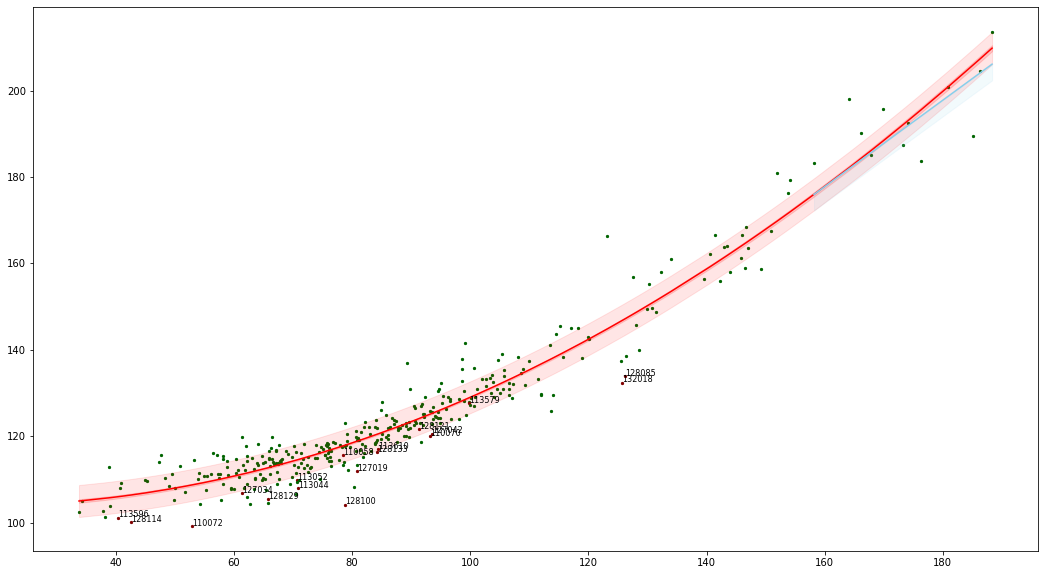

In [38]:
db_df = double_low_arbitrage(data,redeem_df,put_df)
my_df,db_buy_dict = buy_sell_db(db_df,'mycb_list.csv',show_price=True)
lp_df = low_premium_arbitrage(db_df)

In [39]:
lp_df[(lp_df['value'] < 200) & (lp_df['value'] > 180)]

,name,value,price,premium,db_low,lower_deviation,fit_price,low_fit_price,upper_fit_price
id,,,,,,,,,
113585,寿仙转债,185.114495,189.580,2.412294,191.992294,-4.795104,202.871932,199.128415,206.615448
123078,飞凯转债,186.262220,204.500,9.791454,214.291454,2.109706,204.019657,200.274792,207.764523
128091,新天转债,180.863971,200.729,10.983408,211.712408,2.999878,198.621408,194.882755,202.360062
113626,伯特转债,188.350516,213.570,13.389655,226.959655,5.539323,206.107953,202.360594,209.855313


In [40]:
buy_sell_low(lp_df,db_buy_dict,'mycb_list.csv',show_price=True)

Strong Sell 110058 永鼎转债 115.64 162.995 47.355 1.360
Sell 113052 兴业转债 109.8 164.732 55.513 -0.905
Strong Sell 113579 健友转债 127.69 155.661 27.971 1.993
Sell 113610 灵康转债 116.96 155.066 38.583 0.094
Sell 127034 绿茵转债 106.851 179.155 74.277 -0.597
Sell 127042 嘉美转债 120.6 149.683 29.083 -0.777
127056 中特转债 not in lists
Sell 128121 宏川转债 121.599 154.866 33.267 1.032
Sell 128133 奇正转债 116.3 154.565 38.265 -0.353

Add  128100 搜特转债 104.167 133.797 32.143 -8.822
Add  132018 G三峡EB1 132.42 137.795 5.375 -7.428
Add  128085 鸿达转债 133.9 139.974 6.074 -6.683
Add  127003 海印转债 125.9 136.642 10.742 -6.179
Add  113011 光大转债 108.19 142.989 34.799 -5.835
Add  110072 广汇转债 99.19 183.763 87.665 -5.548
Add  113585 寿仙转债 189.58 191.992 2.412 -4.795

Strong Buy 128100 搜特转债 104.167 133.797 32.143 -8.822
Strong Buy 132018 G三峡EB1 132.42 137.795 5.375 -7.428
Strong Buy 128085 鸿达转债 133.9 139.974 6.074 -6.683
Strong Buy 127003 海印转债 125.9 136.642 10.742 -6.179
Strong Buy 113011 光大转债 108.19 142.989 34.799 -5.835
Buy 113585 寿仙转债 18

In [41]:
df2 = lp_df.sort_values('lower_deviation')
df2[0:30]

,name,value,price,premium,db_low,lower_deviation,fit_price,low_fit_price,upper_fit_price
id,,,,,,,,,
128100,搜特转债,78.828860,104.167,32.143228,133.797298,-8.821663,117.931770,114.245339,121.618200
132018,G三峡EB1,125.666051,132.420,5.374521,137.794521,-7.428078,146.740390,143.045534,150.435245
128085,鸿达转债,126.232598,133.900,6.074027,139.974027,-6.683161,147.184765,143.489645,150.879885
127003,海印转债,113.687626,125.900,10.742044,136.642044,-6.178827,137.881628,134.191458,141.571797
113011,光大转债,80.260042,108.190,34.799332,142.989332,-5.834706,118.580004,114.893710,122.266297
110072,广汇转债,52.854913,99.190,87.664673,183.763359,-5.547618,108.709116,105.015880,112.402352
113585,寿仙转债,185.114495,189.580,2.412294,191.992294,-4.795104,202.871932,199.128415,206.615448
132009,17中油EB,65.766663,104.510,58.910298,161.891106,-4.121585,112.691467,109.002636,116.380298
113039,嘉泽转债,125.534443,137.400,9.452033,146.852033,-3.877564,146.637490,142.942695,150.332284


In [42]:
my_df

,name,price,db_low
id,,,
128100,搜特转债,104.167,133.797298
132018,G三峡EB1,132.420,137.794521
128085,鸿达转债,133.900,139.974027
110070,凌钢转债,120.000,148.717297
127042,嘉美转债,120.600,149.682890
127019,国城转债,111.950,150.073943
128133,奇正转债,116.300,154.564640
128121,宏川转债,121.599,154.865730
113610,灵康转债,116.960,155.066335


In [43]:
print(np.percentile(db_df['db_low'],50))
print(np.percentile(db_df['price'],50))
print(np.percentile(lp_df['premium'],50))

170.668161416646
120.6
44.82326051022561


In [44]:
lp_df[(lp_df['value'] < 30) & (lp_df['price']>70)]

,name,value,price,premium,db_low,lower_deviation,fit_price,low_fit_price,upper_fit_price
id,,,,,,,,,


In [45]:
def func(X, a, b, c, d):
    x,y = X
    return a * x ** 2 + b * x +  c * y + d 
    #return a* x + b*1/x + c*y +d

In [46]:
def three_factor_arbitrage(db_df): 
    import scipy.stats as stats
    from scipy.optimize import curve_fit
    
    redeem_default_prob = 0.5    #####probility of force redeem if conditons is satisfied
    time_decay_factor = 0.25  ######hyper parameter simulated time decay 
    redeem_default_days = 20 ####20 days to be forced redeem
    
    regression_data = []
    for cb_id,row in db_df.iterrows():
        name = row['name']
        price = row['price']
        value = row['new_convert_value']
        premium = row['new_premium']
        db_low = row['db_low']
        force_redeem = row['force_redeem']
        convert_value       = float(row['convert_value'])
        redeem_price_ratio  = float(row['redeem_price_ratio'])
        redeem_count_days   = int(row['redeem_count_days'])
        redeem_real_days    = int(row['redeem_real_days'])
        
        today = date.today()
        time_to_exp = 0
        expire_dt = today
        time_to_redeem = 0
        redeem_prob = 1
        if(force_redeem == 'Y'):
            redeem_dt    = row['redeem_dt']
            expire_dt = redeem_dt     
            if(redeem_dt == None):
                time_to_redeem = redeem_default_days/365 
            else:
                redeem_dt = datetime.strptime(redeem_dt,'%Y-%m-%d').date()
                days_interval = redeem_dt-today
                time_to_redeem = days_interval.days/365
            time_to_exp = time_to_redeem
        else:
            maturity_dt  = row['maturity_dt']
            expire_dt = maturity_dt
            maturity_dt = datetime.strptime(maturity_dt,'%Y-%m-%d').date()
            days_interval = maturity_dt-today
            time_to_exp = days_interval.days/365
            redeem_prob = 0
            if(force_redeem == 'X' and convert_value >= redeem_price_ratio):
                days_to_satisfied = redeem_count_days-redeem_real_days if redeem_count_days>redeem_real_days  else 0
                days_to_satisfied += redeem_default_days
                time_to_redeem = days_to_satisfied/365
                redeem_prob = redeem_default_prob*redeem_real_days/redeem_count_days if redeem_count_days>redeem_real_days else redeem_default_prob
                #print("可能强赎:%s,%s,%s,%s,%d,redeem_prob:%.3f"%(cb_id,name,convert_value,price,redeem_real_days,redeem_prob))
                
        time_value = (1-redeem_prob) * time_to_exp ** time_decay_factor + redeem_prob * time_to_redeem ** time_decay_factor
            
        if(price>120 and price/value>1.6):
            #print("remove premium outlier %s %.3f %.3f"%(name,value,price))
            #print("妖债:%s,%s,%s,%s"%(cb_id,name,convert_value,price))
            continue
        if(value>200):
            #print("remove price over 200 %s %.3f %.3f"%(name,value,price))
            continue
        regression_data.append({'id':cb_id,'name':name,'db_low':db_low,'value':value,'price':price,'time':time_to_exp,
                                'expire':expire_dt,'time_value':time_value,'redeem_prob':redeem_prob})

    
    regression_df = pd.DataFrame(regression_data)
    regression_df = regression_df.set_index(['id'])
    #y_df.sort_values('deviation',ascending=True)
    
    x  = regression_df['value']
    y  = regression_df['time_value']
    z = regression_df['price']
    
    popt, pcov = curve_fit(func,(x,y),z)
    print(popt)
    limit_value = (1-popt[1])/2/popt[0]
    intercept = popt[0] * limit_value**2 + popt[1]* limit_value - limit_value
    print(limit_value)
    zfit = func((x,y), *popt)

    n = len(x)
    resid = z - zfit
    s_err = np.sqrt(np.sum(resid**2)/(n - 2))  # standard deviation of the error (residuals)

    td_data = []
    se = 0
    for cb_id,row in regression_df.iterrows():
        cb_name = row['name']
        db_low  = row['db_low']
        value      = row['value']
        time_to_exp = row['time']
        expire_dt  = row['expire']
        time_value = row['time_value']
        price = row['price']
        premium = price/value-1
        fit_price = func((value,time_value), *popt)
        
                     
        origin_time_value = time_to_exp ** time_decay_factor
        origin_fit_price = func((value,origin_time_value), *popt)
        
        if(value>limit_value):
            fit_price = value+intercept + popt[2] * time_value + popt[3]
            origin_fit_price = value+intercept + popt[2] * origin_time_value + popt[3]
         
           ####set minimum fit price
        minimum_fit_price = origin_fit_price/(1+premium)
        if(fit_price < minimum_fit_price):
            fit_price = minimum_fit_price
        
        se += (fit_price-price)**2
        deviation = price/(fit_price)*100-100
        item = {'id':cb_id,'name':cb_name,'value': value,'time_to_exp':time_to_exp,'price':price,
                'premium':premium,'db_low':db_low, 'deviation':deviation,
                'fit_price':fit_price,'ori_fit_price':origin_fit_price,'min_fit_price':minimum_fit_price,
                'expire_dt':expire_dt,'redeem_real_days':redeem_real_days,'redeem_count_days':redeem_count_days,
                'redeem_prob':row['redeem_prob']}
        td_data.append(item)
            

    td_df = pd.DataFrame(td_data)
    td_df = td_df.set_index(['id'])
    td_df = td_df.sort_values('deviation')
    mse = np.square(resid).mean()
    mae = np.absolute(resid).mean()
    print("mse=%.3f"%mse)
    print("mae=%.3f"%mae)
    mse2 = se/n
    print("adjuse mse=%.3f"%mse2)
    return popt,td_df

In [47]:
def buy_sell_three(td_df,file,show_price=False):
    total_number = len(td_df)
    quartile = np.percentile(td_df['deviation'],25) ##first quartile
    tenthtile = np.percentile(td_df['deviation'],10) ##10th percentile
    buy_number  = int(total_number*0.05) ##5th percentile
    add_number = int(total_number*0.02)  ##2th percentile
    
    buy_dict = {i:td_df['name'][i] for i in td_df[0:buy_number].index}
    add_dict = {i:td_df['name'][i] for i in td_df[0:add_number].index}
    sell_count = 0
    holding_dict = dict()
    
    ##sell
    my_list = []
    with open(file) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        for row in csv_reader:
            cb_id,cb_name,position1,position2 = row
            if cb_id not in td_df.index:
                print("%s %s %s"%(cb_id,cb_name,'not in lists'))
                sell_count += 1
                continue
            holding_dict[cb_id] = cb_name
            price = td_df.loc[cb_id]['price']
            value = td_df.loc[cb_id]['value']
            time_to_exp  = td_df.loc[cb_id]['time_to_exp']
            premium = td_df.loc[cb_id]['premium']
            deviation = td_df.loc[cb_id]['deviation']
            fit_price = td_df.loc[cb_id]['fit_price']
            expire_dt = td_df.loc[cb_id]['expire_dt']
            redeem_prob = td_df.loc[cb_id]['redeem_prob']
            item = {'id':cb_id,'name':cb_name,'time_to_exp':time_to_exp,'value':value,'price':price,'premium':premium,
                'deviation':deviation,'expire_dt':expire_dt,'redeem_prob':redeem_prob,'position1':position1,'positon2':position2}
            my_list.append(item)
            if deviation > tenthtile:
                sell = "Sell"
                if(deviation>quartile):
                    sell = "Strong Sell"
                if(show_price):
                    print("%s %s %s %s %.3f %.3f %.3f,redeem_prob:%.2f"
                          %(sell,cb_id,cb_name,time_to_exp,price,premium,deviation,redeem_prob))
                else:
                    print("%s %s %s"%(sell,cb_id,cb_name))
                sell_count += 1
    if(sell_count==0):
        print('No CB to sell')
        
    ##buy
    print()
    for cb_id,cb_name in add_dict.items():
        price = td_df.loc[cb_id]['price']
        time_to_exp  = td_df.loc[cb_id]['time_to_exp']
        premium = td_df.loc[cb_id]['premium']
        deviation = td_df.loc[cb_id]['deviation']
        redeem_prob = td_df.loc[cb_id]['redeem_prob']
        if(show_price):
            print("Add  %s %s %s %.3f %.3f %.3f,redeem_prob:%.2f"
                  %(cb_id,cb_name,time_to_exp,price,premium,deviation,redeem_prob))
        else:
            print("Add  %s %s"%(cb_id,cb_name))
    print()
    for cb_id,cb_name in buy_dict.items():
        price = td_df.loc[cb_id]['price']
        time_to_exp  = td_df.loc[cb_id]['time_to_exp']
        premium = td_df.loc[cb_id]['premium']
        deviation = td_df.loc[cb_id]['deviation']
        redeem_prob = td_df.loc[cb_id]['redeem_prob']
        if cb_id not in holding_dict.keys():
            if(show_price):
                print("Buy %s %s %s %.3f %.3f %.3f,redeem_prob:%.2f"
                      %(cb_id,cb_name,time_to_exp,price,premium,deviation,redeem_prob))
            else:
                print("Buy  %s %s"%(cb_id,cb_name))
        else:
            print("Have %s %s %s %.3f %.3f %.3f,redeem_prob:%.2f"
                      %(cb_id,cb_name,time_to_exp,price,premium,deviation,redeem_prob))
    
    my_df = pd.DataFrame(my_list)
    my_df = my_df.set_index(['id'])
    my_df = my_df.sort_values('deviation',ascending=True)
    return my_df
    

In [48]:
#110048	福能转债 ! 10月6日前不提前赎回
popt,td_df = three_factor_arbitrage(db_df)

[ 3.50589710e-03 -9.91423203e-02  1.01603998e+01  8.96930084e+01]
156.75621517799885
mse=18.011
mae=3.071
adjuse mse=17.713


In [49]:
td_df.loc['113591']

name                       胜达转债
value                 91.593097
time_to_exp            4.273973
price                    118.73
premium                0.296277
db_low               147.983698
deviation             -4.736461
fit_price            124.633203
ori_fit_price        124.633203
min_fit_price         96.147065
expire_dt            2026-06-30
redeem_real_days              0
redeem_count_days            15
redeem_prob                 0.0
Name: 113591, dtype: object

In [50]:
# over 170
#sell over 130
buy_sell_three(td_df,'mycb_list.csv',show_price=True)

Strong Sell 110058 永鼎转债 3.0657534246575344 115.640 0.474 -1.119,redeem_prob:0.00
Strong Sell 113579 健友转债 4.0849315068493155 127.690 0.280 -1.131,redeem_prob:0.00
Sell 113610 灵康转债 4.693150684931507 116.960 0.386 -3.540,redeem_prob:0.00
127056 中特转债 not in lists
Sell 128121 宏川转债 4.317808219178082 121.599 0.333 -2.316,redeem_prob:0.00

Add  128100 搜特转债 3.96986301369863 104.167 0.321 -11.727,redeem_prob:0.00
Add  128085 鸿达转债 3.736986301369863 133.900 0.061 -9.017,redeem_prob:0.00
Add  110072 广汇转债 4.405479452054794 99.190 0.877 -8.973,redeem_prob:0.00
Add  123107 温氏转债 5.016438356164383 129.510 0.135 -6.963,redeem_prob:0.00
Add  128129 青农转债 4.424657534246576 105.430 0.604 -6.747,redeem_prob:0.00
Add  113585 寿仙转债 4.213698630136986 189.580 0.024 -6.710,redeem_prob:0.00
Add  113039 嘉泽转债 4.421917808219178 137.400 0.095 -6.677,redeem_prob:0.00

Have 128100 搜特转债 3.96986301369863 104.167 0.321 -11.727,redeem_prob:0.00
Have 128085 鸿达转债 3.736986301369863 133.900 0.061 -9.017,redeem_prob:0.00
Have 1100

,name,time_to_exp,value,price,premium,deviation,expire_dt,redeem_prob,position1,positon2
id,,,,,,,,,,
128100,搜特转债,3.969863,78.828860,104.167,0.321432,-11.726751,2026-03-11,0.0,10,10
128085,鸿达转债,3.736986,126.232598,133.900,0.060740,-9.016808,2025-12-16,0.0,20,10
110072,广汇转债,4.405479,52.854913,99.190,0.876647,-8.972536,2026-08-17,0.0,30,20
128129,青农转债,4.424658,65.726953,105.430,0.604060,-6.747237,2026-08-24,0.0,10,10
113044,大秦转债,4.728767,70.809088,107.940,0.524381,-6.329817,2026-12-13,0.0,0,20
132018,G三峡EB1,2.049315,125.666051,132.420,0.053745,-6.175189,2024-04-09,0.5,30,0
127019,国城转债,4.312329,80.829537,111.950,0.385014,-6.103062,2026-07-14,0.0,0,10
128114,正邦转债,4.235616,42.549374,100.216,1.355287,-5.810142,2026-06-16,0.0,10,10
113052,兴业转债,5.767123,70.604973,109.800,0.555131,-5.275802,2027-12-27,0.0,10,30


In [51]:
td_df[0:20]

,name,value,time_to_exp,price,premium,db_low,deviation,fit_price,ori_fit_price,min_fit_price,expire_dt,redeem_real_days,redeem_count_days,redeem_prob
id,,,,,,,,,,,,,,
128100,搜特转债,78.828860,3.969863,104.167,0.321432,133.797298,-11.726751,118.005172,118.005172,89.300961,2026-03-11,0,15,0.0
128085,鸿达转债,126.232598,3.736986,133.900,0.060740,139.974027,-9.016808,147.170039,147.170039,138.742766,2025-12-16,0,15,0.0
110072,广汇转债,52.854913,4.405479,99.190,0.876647,183.763359,-8.972536,108.967114,108.967114,58.064798,2026-08-17,0,15,0.0
123107,温氏转债,114.061944,5.016438,129.510,0.135436,143.053567,-6.962960,139.202623,139.202623,122.598424,2027-03-28,0,15,0.0
128129,青农转债,65.726953,4.424658,105.430,0.604060,164.643331,-6.747237,113.058312,113.058312,70.482580,2026-08-24,0,15,0.0
113585,寿仙转债,185.114495,4.213699,189.580,0.024123,191.992294,-6.710087,203.215968,203.215968,198.429272,2026-06-08,0,15,0.0
113039,嘉泽转债,125.534443,4.421918,137.400,0.094520,146.852033,-6.676665,147.230057,147.230057,134.515598,2026-08-23,0,15,0.0
113044,大秦转债,70.809088,4.728767,107.940,0.524381,159.468080,-6.329817,115.234108,115.234108,75.594054,2026-12-13,0,15,0.0
118002,天合转债,127.915367,0.054795,130.500,0.020206,132.520580,-6.311703,139.291677,139.291677,136.532919,None,0,15,1.0


today quartile 160.95636744926884


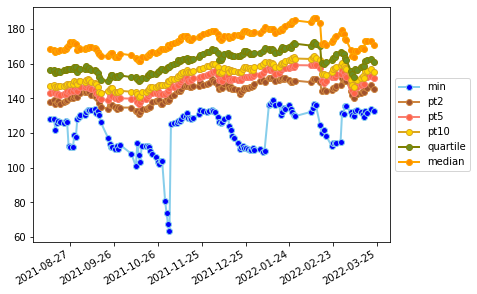

In [52]:
save_historical_data(db_df,'db_low','db_history.csv')
plot_history('db_history.csv')

today quartile 29.65017381888894


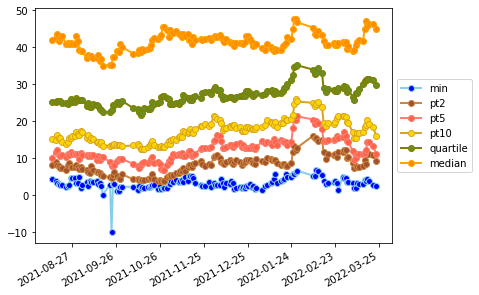

In [53]:
save_historical_data(lp_df,'premium','premium_history.csv')
plot_history('premium_history.csv')

today quartile 114.0935


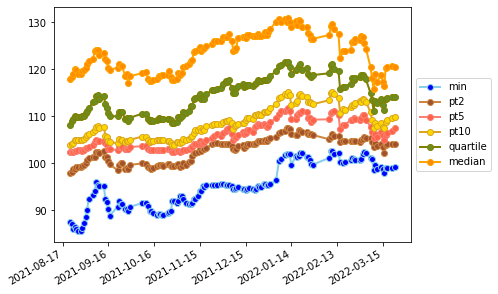

In [54]:
save_historical_data(db_df,'price','price_history.csv')
plot_history('price_history.csv')

In [55]:
td_df[(td_df['time_to_exp']<0)]

,name,value,time_to_exp,price,premium,db_low,deviation,fit_price,ori_fit_price,min_fit_price,expire_dt,redeem_real_days,redeem_count_days,redeem_prob
id,,,,,,,,,,,,,,


In [56]:
value = 137.04*0.94
year = 0.03
limit_value = 154.03443402217655
intercept = popt[0] * limit_value**2 + popt[1]* limit_value - limit_value
time_value = year**0.25
func((value,time_value),*popt)
#value+intercept + popt[2] * time_value + popt[3]

139.3270446670657

In [57]:
147*0.943

138.62099999999998

In [58]:
137.39/145

0.9475172413793103

In [59]:
140+151

291

In [60]:
130/138

0.9420289855072463

In [61]:
137*0.94

128.78